In this notebook, I will check up on the test run results of chrX and chr10.

In [1]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats

/faststorage/project/baboondiversity/people/eriks/second_analysis_baboons/scripts/notebook_settings_lean.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', 'png')


In [2]:
def length_to_windows(length_df, pops, window_size=1000000):
    #pops = sorted(length_df["reference"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.length)//window_size
            if x == 0:
                overall_dict[row["reference"]][i] += int(row.length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["reference"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["reference"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["reference"]][i+x] += int(row.length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def create_paint_df_ind(df, ind, mapping, ns_map):
    d = {}
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

In [3]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

In [4]:
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_females/"

In [5]:
input_file = rfmix_path + "chrX.msp.tsv"
chrX_test = pd.read_csv(input_file, sep = "\t", header=1)
file = open(input_file, 'r')
line1 = file.readline()
file.close()

In [6]:
number_subpop_mapping = {}
for subpop in line1.strip().split("\t"):
    # Splitting to create lists containing two values - subpop and number.
    subpop_number = subpop.split(": ")[-1].split("=")
    number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]

In [7]:
number_subpop_mapping

{0: 'Hamadryas, Ethiopia',
 1: 'Kindae, Zambia',
 2: 'Papio, Senegal',
 3: 'Ursinus, Zambia'}

In [8]:
# North is 1, South is 0
north_south_mapping = {'Hamadryas, Ethiopia': 1, 'Papio, Senegal': 1, 'Kindae, Zambia': 0, 'Ursinus, Zambia': 0}

In [9]:
meta_data_samples.loc[meta_data_samples.Origin == "Gombe, Tanzania"]

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index,C_origin
29,PD_0218,02GNM1200916,Knauf/Chuma/Roos,Papio,anubis,"Gombe, Tanzania",M,"Gombe, Ulanga, Morogoro, Coastal Zone, Tanzania",36.797452,-8.857992,29,"Anubis, Tanzania"
30,PD_0219,03GNF8200916,Knauf/Chuma/Roos,Papio,anubis,"Gombe, Tanzania",F,"Gombe, Ulanga, Morogoro, Coastal Zone, Tanzania",36.797452,-8.857992,30,"Anubis, Tanzania"
31,PD_0220,08GNM1210916,Knauf/Chuma/Roos,Papio,anubis,"Gombe, Tanzania",M,"Gombe, Ulanga, Morogoro, Coastal Zone, Tanzania",36.797452,-8.857992,31,"Anubis, Tanzania"
32,PD_0221,09GNF1210916,Knauf/Chuma/Roos,Papio,anubis,"Gombe, Tanzania",F,"Gombe, Ulanga, Morogoro, Coastal Zone, Tanzania",36.797452,-8.857992,32,"Anubis, Tanzania"
33,PD_0222,10GNF1210916,Knauf/Chuma/Roos,Papio,anubis,"Gombe, Tanzania",F,"Gombe, Ulanga, Morogoro, Coastal Zone, Tanzania",36.797452,-8.857992,33,"Anubis, Tanzania"
88,PD_0504,56 / 13GNM1210916,Knauf/Chuma/Roos,Papio,anubis,"Gombe, Tanzania",M,"Gombe, Ulanga, Morogoro, Coastal Zone, Tanzania",36.797452,-8.857992,88,"Anubis, Tanzania"
89,PD_0505,57 / 19GNM2220916,Knauf/Chuma/Roos,Papio,anubis,"Gombe, Tanzania",M,"Gombe, Ulanga, Morogoro, Coastal Zone, Tanzania",36.797452,-8.857992,89,"Anubis, Tanzania"
90,PD_0506,58 / 20GNF5220916,Knauf/Chuma/Roos,Papio,anubis,"Gombe, Tanzania",F,"Gombe, Ulanga, Morogoro, Coastal Zone, Tanzania",36.797452,-8.857992,90,"Anubis, Tanzania"
91,PD_0507,59 / 21GNF1220916,Knauf/Chuma/Roos,Papio,anubis,"Gombe, Tanzania",F,"Gombe, Ulanga, Morogoro, Coastal Zone, Tanzania",36.797452,-8.857992,91,"Anubis, Tanzania"
92,PD_0508,60 / 22GNM1220916,Knauf/Chuma/Roos,Papio,anubis,"Gombe, Tanzania",M,"Gombe, Ulanga, Morogoro, Coastal Zone, Tanzania",36.797452,-8.857992,92,"Anubis, Tanzania"


<AxesSubplot:xlabel='PD_0506.0', ylabel='Count'>

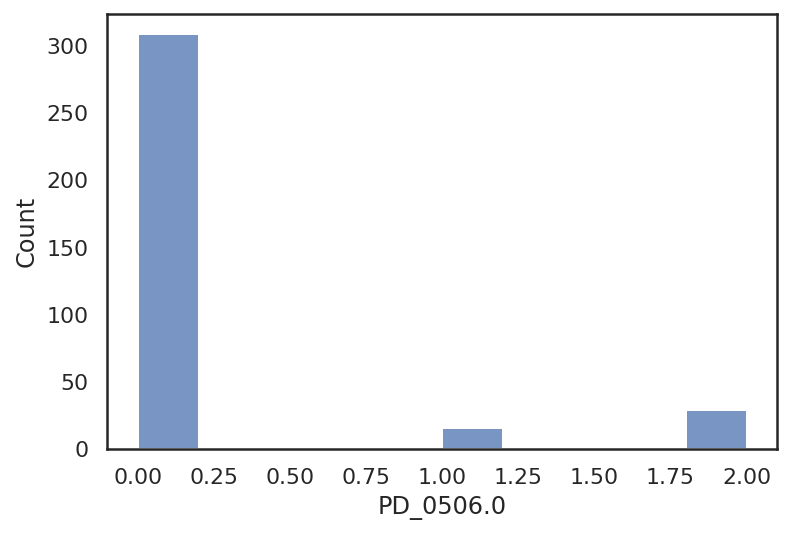

In [10]:
sns.histplot(chrX_test["PD_0506.0"])

In [11]:
df_l = []
for hap in chrX_test.columns[6:]:
    df_l.append(create_paint_df_ind(chrX_test, hap, number_subpop_mapping, north_south_mapping))
length_df = pd.concat(df_l)

In [12]:
length_df

,pos,end_pos,length,reference,n/s,individual,haplotype
0,37,102015,101979,"Ursinus, Zambia",0,Sci_16066,0
1,102016,2125877,2023862,"Ursinus, Zambia",0,Sci_16066,0
2,2125878,3850658,1724781,"Kindae, Zambia",0,Sci_16066,0
3,3850659,4207786,357128,"Kindae, Zambia",0,Sci_16066,0
4,4207787,5131341,923555,"Ursinus, Zambia",0,Sci_16066,0
...,...,...,...,...,...,...,...
347,140836282,141477147,640866,"Kindae, Zambia",0,PD_0774,1
348,141477148,141609608,132461,"Papio, Senegal",1,PD_0774,1
349,141609609,142188881,579273,"Ursinus, Zambia",0,PD_0774,1
350,142188882,142877353,688472,"Ursinus, Zambia",0,PD_0774,1


Just plotting with the efficient and raw dataframe.

In [13]:
sampling_locations = meta_data_samples.loc[meta_data_samples.Species.isin(["cynocephalus", "anubis"])].Origin.unique()

In [14]:
location_l = []
for sampling_location in sampling_locations:
    samples = meta_data_samples.loc[(meta_data_samples.Sex == "F") & (meta_data_samples.Origin == sampling_location)].PGDP_ID
    s_df = length_df.loc[length_df.individual.isin(samples)]
    s_df = s_df.groupby("pos").mean().reset_index()
    s_df["Origin"] = sampling_location
    location_l.append(s_df)
location_df = pd.concat(location_l)

In [15]:
location_df

,pos,end_pos,length,n/s,Origin
0,37,102015.0,101979.0,0.0,"Mikumi, Tanzania"
1,102016,2125877.0,2023862.0,0.0,"Mikumi, Tanzania"
2,2125878,3850658.0,1724781.0,0.0,"Mikumi, Tanzania"
3,3850659,4207786.0,357128.0,0.0,"Mikumi, Tanzania"
4,4207787,5131341.0,923555.0,0.0,"Mikumi, Tanzania"
...,...,...,...,...,...
347,140836282,141477147.0,640866.0,1.0,"Gog Woreda, Gambella region, Ethiopia"
348,141477148,141609608.0,132461.0,1.0,"Gog Woreda, Gambella region, Ethiopia"
349,141609609,142188881.0,579273.0,1.0,"Gog Woreda, Gambella region, Ethiopia"
350,142188882,142877353.0,688472.0,1.0,"Gog Woreda, Gambella region, Ethiopia"


In [16]:
meta_data_samples.loc[meta_data_samples.C_origin == "Anubis, Ethiopia"]

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index,C_origin
152,PD_0720,39955_CK_01,Rogers,Papio,anubis,"Gog Woreda, Gambella region, Ethiopia",M,"Gambrella National Park, Ethiopia",34.179063,8.073969,152,"Anubis, Ethiopia"
153,PD_0721,39956_CK_02,Rogers,Papio,anubis,"Gog Woreda, Gambella region, Ethiopia",F,"Gambrella National Park, Ethiopia",34.179063,8.073969,153,"Anubis, Ethiopia"
154,PD_0722,39957_CK_05,Rogers,Papio,anubis,"Gog Woreda, Gambella region, Ethiopia",M,"Gambrella National Park, Ethiopia",34.179063,8.073969,154,"Anubis, Ethiopia"
155,PD_0723,39958_RY_01,Rogers,Papio,anubis,"Gog Woreda, Gambella region, Ethiopia",M,"Gambrella National Park, Ethiopia",34.179063,8.073969,155,"Anubis, Ethiopia"
156,PD_0724,39959_RY_15,Rogers,Papio,anubis,"Gog Woreda, Gambella region, Ethiopia",F,"Gambrella National Park, Ethiopia",34.179063,8.073969,156,"Anubis, Ethiopia"
157,PD_0725,39961_CK_03,Rogers,Papio,anubis,"Gog Woreda, Gambella region, Ethiopia",M,"Gambrella National Park, Ethiopia",34.179063,8.073969,157,"Anubis, Ethiopia"
158,PD_0726,39962_CK_04,Rogers,Papio,anubis,"Gog Woreda, Gambella region, Ethiopia",F,"Gambrella National Park, Ethiopia",34.179063,8.073969,158,"Anubis, Ethiopia"
159,PD_0727,39964_CK_06,Rogers,Papio,anubis,"Gog Woreda, Gambella region, Ethiopia",M,"Gambrella National Park, Ethiopia",34.179063,8.073969,159,"Anubis, Ethiopia"
160,PD_0728,39965_CK_07,Rogers,Papio,anubis,"Gog Woreda, Gambella region, Ethiopia",M,"Gambrella National Park, Ethiopia",34.179063,8.073969,160,"Anubis, Ethiopia"
161,PD_0729,39966_CM_01,Rogers,Papio,anubis,"Gog Woreda, Gambella region, Ethiopia",M,"Gambrella National Park, Ethiopia",34.179063,8.073969,161,"Anubis, Ethiopia"


In [17]:
serengeti = location_df.loc[location_df.Origin == "Serengeti, Tanzania"]
tarangire = location_df.loc[location_df.Origin == "Tarangire, Tanzania"]
gog = location_df.loc[location_df.Origin == "Gog Woreda, Gambella region, Ethiopia"]
gombe = location_df.loc[location_df.Origin == "Gombe, Tanzania"]
mikumi = location_df.loc[location_df.Origin == "Mikumi, Tanzania"]
ruaha = location_df.loc[location_df.Origin == "Ruaha, Tanzania"]
mahale = location_df.loc[location_df.Origin == "Mahale, Tanzania"]
issa = location_df.loc[location_df.Origin == "Issa Valley, Tanzania"]
manyara = location_df.loc[location_df.Origin == "Lake Manyara, Tanzania"]

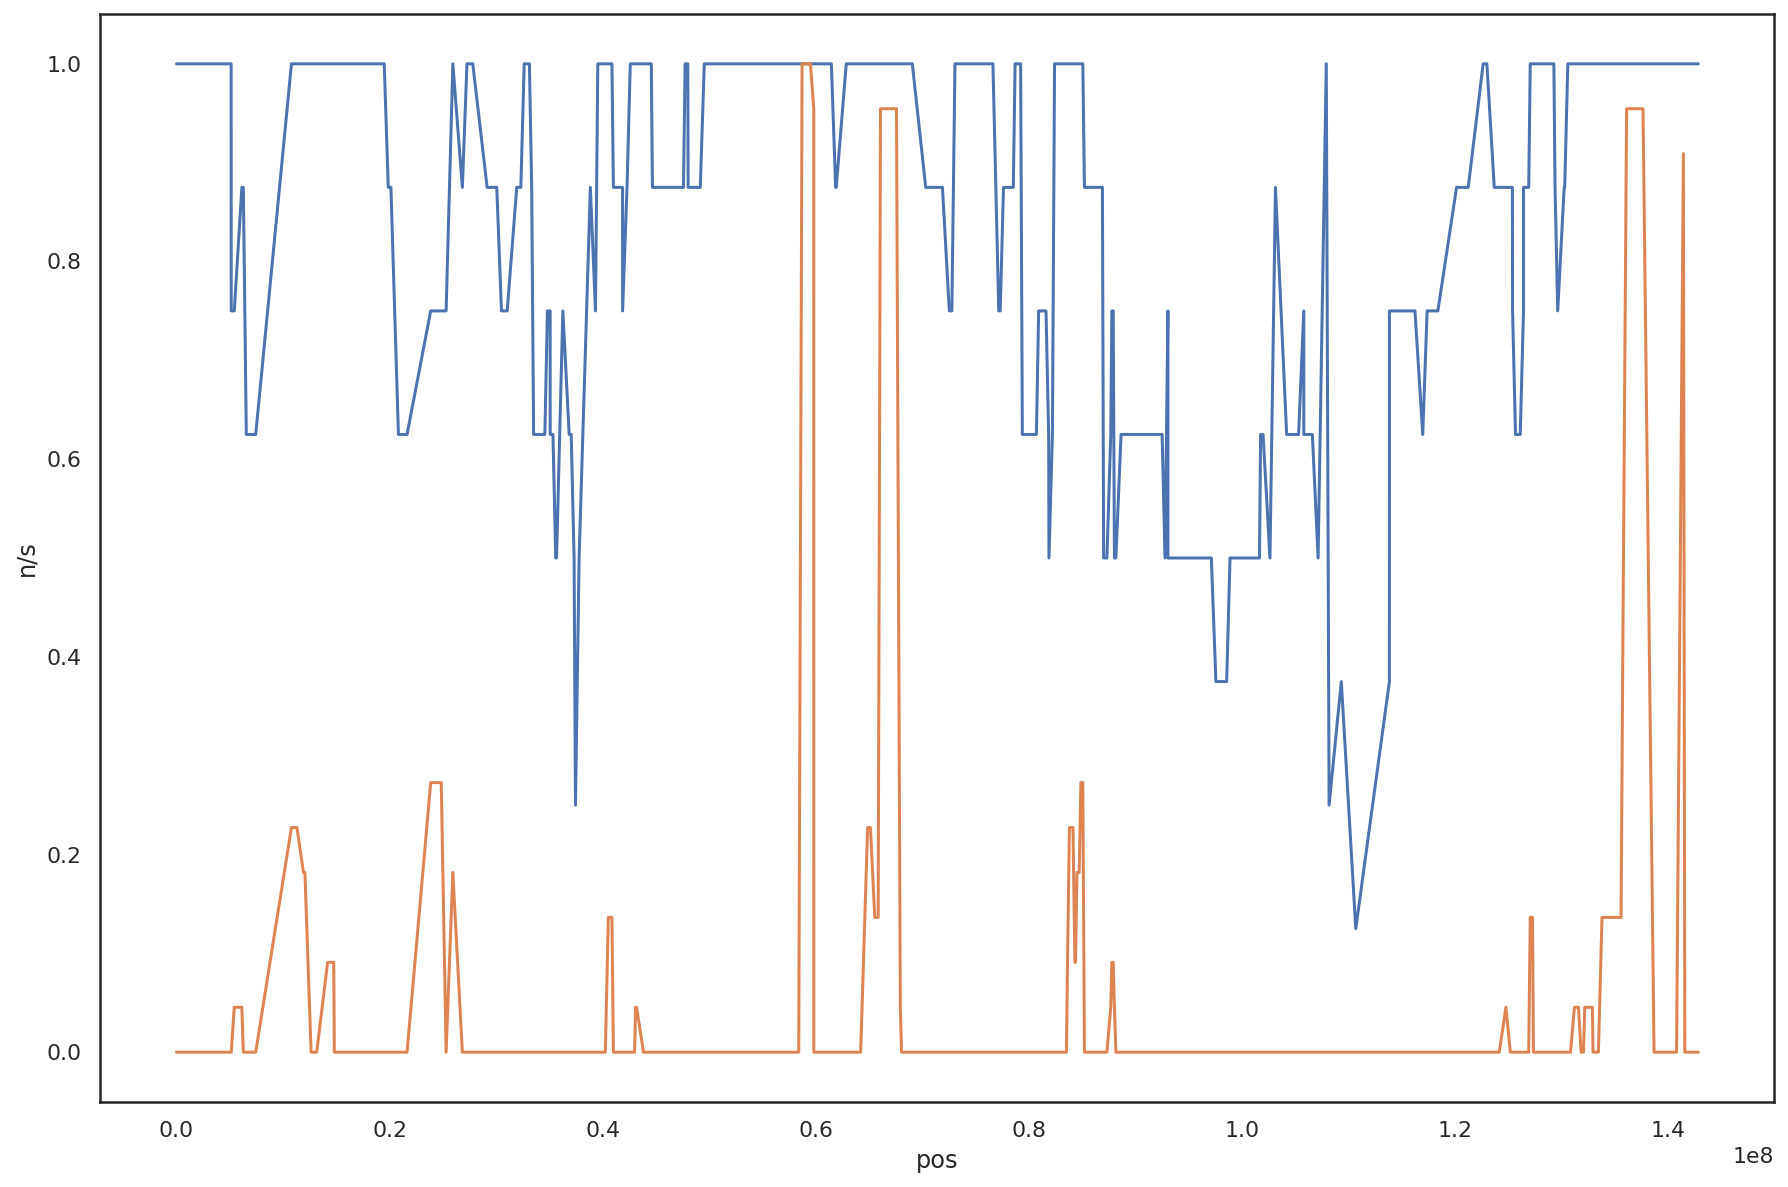

In [18]:
plt.figure(figsize=(15,10))
g = sns.lineplot(data=tarangire, x="pos", y="n/s")
g = sns.lineplot(data=mikumi, x="pos", y="n/s")
#g = sns.lineplot(data=issa, x="pos", y="n/s")


In [19]:
tarangire["n/s"].median(), issa["n/s"].median()

(0.875, 0.0)

In [20]:
stats.spearmanr(tarangire["n/s"], mikumi["n/s"])

SpearmanrResult(correlation=0.3281988471200233, pvalue=2.7666173956281814e-10)

In [21]:
stats.spearmanr([1, 0, 0, 0.1, 0, 0, 0, 0], [1, 1, 0, 1, 1, 1, 1, 1])

SpearmanrResult(correlation=0.21597969886241555, pvalue=0.6074553965533899)

In [22]:
import geneinfo as gi
gi.email('your@email.com')

In [23]:
%env ftp_proxy http://proxyserv:3128
%env http_proxy http://proxyserv:3128
%env https_proxy http://proxyserv:3128

env: ftp_proxy=http://proxyserv:3128
env: http_proxy=http://proxyserv:3128
env: https_proxy=http://proxyserv:3128


Checking specific areas with gene info and relate Trees

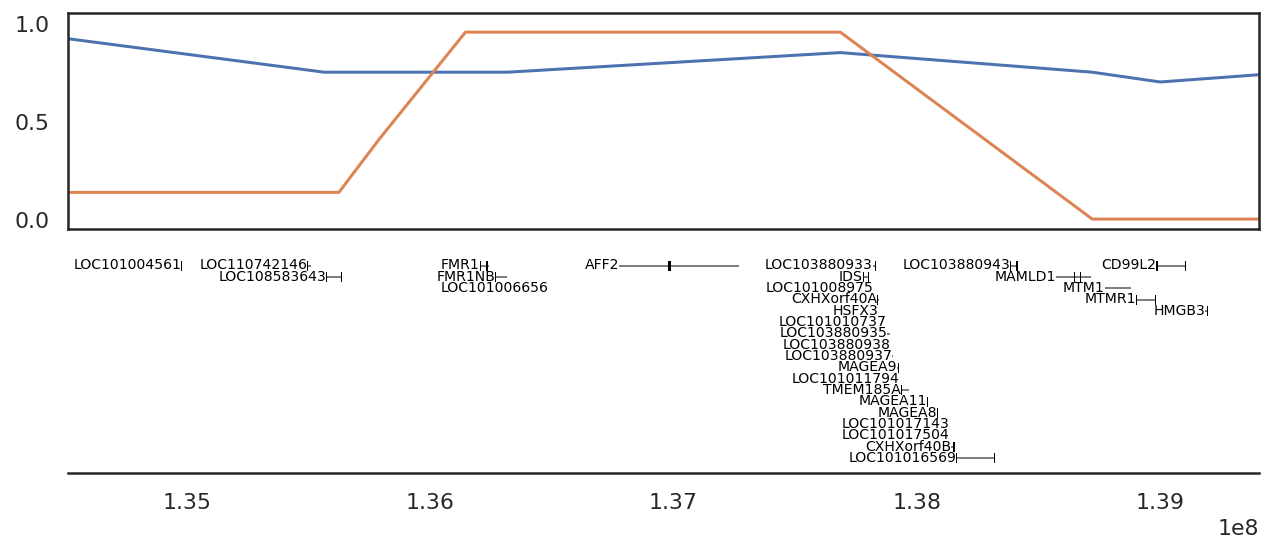

In [24]:
ax = gi.gene_plot('chrX', 134836282, 139188881, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(serengeti.pos, gombe["n/s"])
ax.plot(mikumi.pos, mikumi["n/s"])
plt.tight_layout()

In [25]:
window_size = 100000

relate_sele = pd.read_csv("../results/all_individuals_relate/chromX_selection.sele", sep=" ")
relate_sele["-log10 P-value"] = -relate_sele["when_mutation_has_freq2"]

In [26]:
relate_sele.loc[(relate_sele.pos > 134836282)
                & (relate_sele.pos < 139188881)].sort_values(by= "-log10 P-value")[-20:]

,pos,rs_id,3571428.500000,357142.937500,257030.656250,184981.281250,133128.375000,95810.585938,68953.507812,49624.847656,...,184.981262,133.128357,95.810577,68.953499,49.624844,35.714287,0.000000,when_DAF_is_half,when_mutation_has_freq2,-log10 P-value
1069300,136667664,X:136667664:C:T,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.572780,-1.992120,-1.354970,-2.021110,-2.351550,-0.678501,0,-2.489200,-4.87075,4.87075
1054470,134936248,X:134936248:A:G,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.317080,-1.877080,-0.996068,-1.029680,-1.405130,-1.668020,0,-2.312170,-4.87534,4.87534
1066373,136174464,X:136174464:C:T,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-2.608120,-3.333730,-2.153870,-3.149330,-2.083900,-2.025570,0,-3.079720,-4.88274,4.88274
1054469,134936247,X:134936247:C:G,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.285310,-1.448630,-0.918635,-1.216110,-1.598040,-1.151210,0,-3.185090,-4.92417,4.92417
1082103,138933347,X:138933347:A:G,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.258130,-0.949800,-1.219750,-1.141520,-1.226030,-1.258090,0,-2.154620,-4.92583,4.92583
1069199,136645963,X:136645963:A:C,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-2.104970,-1.503940,-1.221170,-1.991130,-1.798120,-2.040620,0,-2.489200,-4.98698,4.98698
1063698,135811662,X:135811662:C:A,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-3.183200,-2.193420,-2.933460,-2.326740,-1.349740,-1.383210,0,-3.407390,-5.01885,5.01885
1061133,135530914,X:135530914:A:G,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.085216,-0.250451,-0.443548,-0.757146,-0.421181,-0.278197,0,-0.546795,-5.12134,5.12134
1068829,136592005,X:136592005:A:G,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-2.373740,-2.049360,-2.940570,-1.569350,-1.289670,-1.169470,0,-2.553690,-5.19064,5.19064
1061885,135620085,X:135620085:T:G,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-3.030340,-1.677090,-2.364590,-1.768830,-0.836097,-0.276308,0,-2.935300,-5.20152,5.20152


In [27]:
list(relate_sele.loc[(relate_sele.pos > 134836282)
                & (relate_sele.pos < 139188881)].sort_values(by= "-log10 P-value")[-20:].pos)

[136667664,
 134936248,
 136174464,
 134936247,
 138933347,
 136645963,
 135811662,
 135530914,
 136592005,
 135620085,
 136687305,
 136693790,
 136694036,
 136694565,
 135690130,
 136708863,
 136709628,
 136708589,
 136643155,
 135282108]

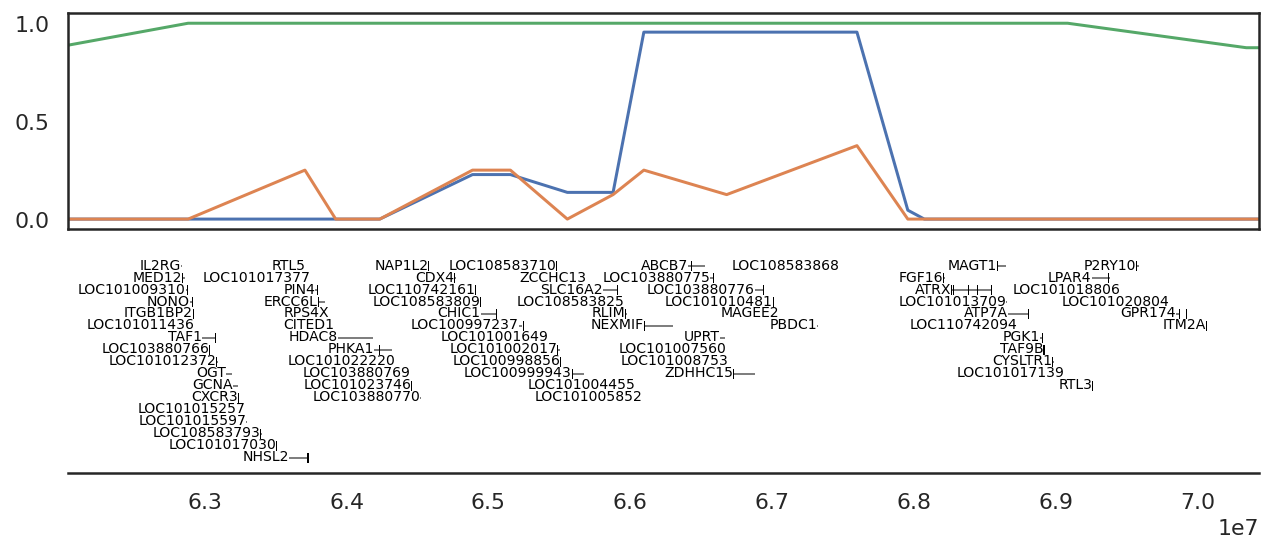

In [28]:
ax = gi.gene_plot('chrX', 62836282, 70188881, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(mikumi.pos, mikumi["n/s"])
ax.plot(ruaha.pos, ruaha["n/s"])
ax.plot(tarangire.pos, tarangire["n/s"])
plt.tight_layout()

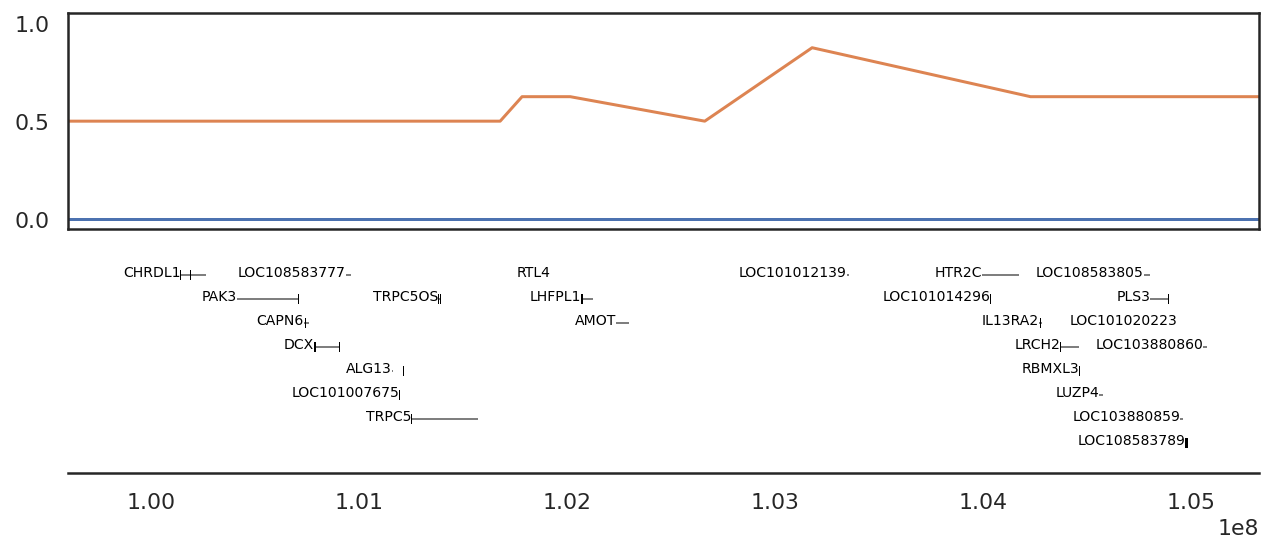

In [29]:
ax = gi.gene_plot('chrX', 100188881, 105188881, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(mikumi.pos, mikumi["n/s"])
#ax.plot(ruaha.pos, ruaha["n/s"])
ax.plot(tarangire.pos, tarangire["n/s"])
plt.tight_layout()

In [30]:
relate_sele.loc[(relate_sele.pos > 62836282)
                & (relate_sele.pos < 70188881)].sort_values(by= "-log10 P-value")[-20:]

,pos,rs_id,3571428.500000,357142.937500,257030.656250,184981.281250,133128.375000,95810.585938,68953.507812,49624.847656,...,184.981262,133.128357,95.810577,68.953499,49.624844,35.714287,0.000000,when_DAF_is_half,when_mutation_has_freq2,-log10 P-value
496655,68193832,X:68193832:T:C,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-2.522670,-2.797310,-2.386550,-1.108100,-1.039410,-0.833347,0,-3.32035,-5.27263,5.27263
504724,69344546,X:69344546:C:G,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.479703,-0.335361,-0.379986,-0.187126,-0.400153,-0.230242,0,-1.47587,-5.28645,5.28645
494718,67991151,X:67991151:A:C,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.701340,-1.167220,-1.058120,-0.884994,-0.429144,-0.521271,0,-3.68894,-5.46043,5.46043
494719,67991152,X:67991152:A:C,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.701340,-1.167220,-1.058120,-0.884994,-0.429144,-0.521271,0,-3.68894,-5.46043,5.46043
485891,66499501,X:66499501:T:G,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-4.713100,-4.057410,-2.726100,-2.441850,-2.096700,-0.732644,0,-4.34452,-5.50320,5.50320
486278,66559980,X:66559980:T:C,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-3.072450,-3.013110,-2.989100,-2.695520,-2.126840,-0.521216,0,-3.76681,-5.51701,5.51701
486292,66562345,X:66562345:C:G,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-2.801660,-3.398450,-2.627840,-2.471090,-0.939397,-0.761879,0,-3.59640,-5.51701,5.51701
485962,66508866,X:66508866:T:C,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-5.418660,-3.805010,-3.203160,-1.907880,-0.925388,-0.968129,0,-5.16456,-5.51701,5.51701
482974,65911865,X:65911865:G:C,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.756460,-1.081670,-0.613462,-0.236093,-0.701741,-0.119465,0,-1.95112,-5.62427,5.62427
485412,66414280,X:66414280:G:A,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-3.148060,-3.343310,-1.823060,-2.023580,-1.629390,-1.198460,0,-3.78064,-5.63143,5.63143


In [31]:
relate_sele.loc[(relate_sele.pos > 66836282)
                & (relate_sele.pos < 69188881)]

,pos,rs_id,3571428.500000,357142.937500,257030.656250,184981.281250,133128.375000,95810.585938,68953.507812,49624.847656,...,184.981262,133.128357,95.810577,68.953499,49.624844,35.714287,0.000000,when_DAF_is_half,when_mutation_has_freq2,-log10 P-value
488315,66836315,X:66836315:A:G,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.000000,...,-0.000034,-0.000006,-0.000031,-0.000020,-0.000037,-0.000003,0,-0.036898,-0.005843,0.005843
488316,66836422,X:66836422:A:T,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.000000,...,-0.201497,-0.328826,-0.465002,-0.229322,-0.304520,-0.453010,0,-0.563679,-0.260787,0.260787
488317,66836424,X:66836424:T:C,1,1.0,1.0,1.0,1.0,1.0,-1.39033,-0.863161,...,-0.436627,-0.324846,-0.250705,-0.169646,-0.130522,-0.082756,0,-1.190810,-1.390330,1.390330
488318,66836477,X:66836477:C:T,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.000000,...,-0.000030,-0.000009,-0.000031,-0.000025,-0.000051,-0.000014,0,-0.057015,-0.019488,0.019488
488319,66836478,X:66836478:A:G,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.000000,...,-0.136636,-0.100665,-0.041706,-0.096184,0.000000,0.000000,0,-0.308829,-0.558470,0.558470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503117,69188333,X:69188333:T:C,1,1.0,1.0,1.0,1.0,1.0,-0.53307,-0.607459,...,-0.247200,-0.257856,-0.346588,-0.432734,-0.889886,-0.821788,0,-0.068357,-0.533070,0.533070
503118,69188357,X:69188357:C:T,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.000000,...,-0.000040,-0.000028,0.000000,-0.000010,-0.000056,-0.000026,0,-0.034778,-0.102179,0.102179
503119,69188408,X:69188408:C:T,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.000000,...,-0.000034,-0.000024,-0.000006,-0.000004,-0.000040,-0.000029,0,-0.249118,-0.238847,0.238847
503120,69188473,X:69188473:A:G,1,1.0,1.0,1.0,1.0,1.0,-1.98900,-1.687980,...,-0.125697,-0.096910,-0.083206,-0.054499,-0.032365,-0.015878,0,-0.289949,-1.989000,1.989000


In [32]:
list(relate_sele.loc[(relate_sele.pos > 100188881)
                & (relate_sele.pos < 105188881)].sort_values(by= "-log10 P-value")[-20:].pos)

[102837585,
 100927013,
 100617714,
 100295623,
 100618869,
 103947184,
 102558860,
 104107851,
 101694377,
 104750148,
 104749739,
 104692633,
 104227020,
 104716552,
 101696933,
 101696360,
 101696102,
 104731433,
 104724172,
 101396897]

In [33]:
relate_sele.loc[(relate_sele.pos > 100188881)
                & (relate_sele.pos < 105188881)].sort_values(by= "-log10 P-value")[-20:]

,pos,rs_id,3571428.500000,357142.937500,257030.656250,184981.281250,133128.375000,95810.585938,68953.507812,49624.847656,...,184.981262,133.128357,95.810577,68.953499,49.624844,35.714287,0.000000,when_DAF_is_half,when_mutation_has_freq2,-log10 P-value
792771,102837585,X:102837585:A:G,1,1.0,1.0,1.0,1.0,1.0,1.0,1.00000,...,-1.965910,-1.363090,-0.803493,-1.345390,-1.012840,-0.148448,0,-3.688500,-5.23420,5.23420
774749,100927013,X:100927013:A:G,1,1.0,1.0,1.0,1.0,1.0,1.0,1.00000,...,-1.202970,-1.085720,-1.315980,-0.410032,-0.552972,-0.314868,0,-1.947290,-5.25183,5.25183
773134,100617714,X:100617714:C:G,1,1.0,1.0,1.0,1.0,1.0,1.0,1.00000,...,-0.859795,-0.671122,-0.762029,-0.936356,-0.821122,-1.378550,0,-1.985850,-5.25325,5.25325
771088,100295623,X:100295623:T:C,1,1.0,1.0,1.0,1.0,1.0,1.0,1.00000,...,-1.304210,-1.590250,-1.581460,-1.428110,-0.616914,-0.340407,0,-2.133440,-5.40992,5.40992
773139,100618869,X:100618869:G:C,1,1.0,1.0,1.0,1.0,1.0,1.0,1.00000,...,-2.931480,-2.138150,-1.106040,-2.594810,-2.218440,-2.380350,0,-3.479090,-5.44860,5.44860
802299,103947184,X:103947184:C:T,1,1.0,1.0,1.0,1.0,1.0,1.0,1.00000,...,-0.386842,-0.402092,-0.309470,-0.432269,-0.338794,-0.275118,0,-1.037000,-5.67138,5.67138
789792,102558860,X:102558860:C:T,1,1.0,1.0,1.0,1.0,1.0,1.0,1.00000,...,-0.714727,-0.542339,-0.686488,-0.551568,-0.303058,-0.240150,0,-2.327400,-5.71113,5.71113
804042,104107851,X:104107851:C:T,1,1.0,1.0,1.0,1.0,1.0,1.0,-5.42165,...,-0.624192,-0.425521,-0.347033,-0.196816,-0.139057,-0.054737,0,-2.524420,-5.89509,5.89509
781265,101694377,X:101694377:G:A,1,1.0,1.0,1.0,1.0,1.0,1.0,1.00000,...,-2.488190,-1.581040,-1.025090,-0.463983,-0.591138,-0.204400,0,-3.248630,-5.93540,5.93540
808088,104750148,X:104750148:C:T,1,1.0,1.0,1.0,1.0,1.0,1.0,1.00000,...,-1.958120,-1.788650,-1.910600,-1.126460,-1.605080,-1.173950,0,-4.561920,-5.99688,5.99688


In [34]:
relate_sele.loc[(relate_sele.pos > 101393897)
                & (relate_sele.pos < 101400897)].sort_values(by= "-log10 P-value")

,pos,rs_id,3571428.500000,357142.937500,257030.656250,184981.281250,133128.375000,95810.585938,68953.507812,49624.847656,...,184.981262,133.128357,95.810577,68.953499,49.624844,35.714287,0.000000,when_DAF_is_half,when_mutation_has_freq2,-log10 P-value
778001,101396859,X:101396859:C:T,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.269431,-0.337436,-0.441178,-0.618874,-0.794165,-0.000031,0,-0.58823,-0.003693,0.003693
777998,101396725,X:101396725:A:G,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.269431,-0.337436,-0.441178,-0.618874,-0.794165,-0.000031,0,-0.58823,-0.003693,0.003693
777986,101396158,X:101396158:C:T,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.806247,-0.368130,-0.427717,-0.596343,-0.794165,-0.000031,0,-1.03217,-0.006100,0.006100
777984,101396073,X:101396073:A:G,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.806247,-0.368130,-0.427717,-0.596343,-0.794165,-0.000031,0,-1.03217,-0.006100,0.006100
777980,101395425,X:101395425:A:G,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.891902,-0.347298,-0.441178,-0.555189,-0.696302,-0.000017,0,-1.01041,-0.007000,0.007000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778011,101397182,X:101397182:G:C,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-3.619740,-1.927350,-1.007580,-0.435917,-0.475140,-0.275810,0,-4.22799,-3.828550,3.828550
778016,101397369,X:101397369:T:A,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-3.619740,-1.927350,-1.007580,-0.435917,-0.475140,-0.275810,0,-4.22799,-3.828550,3.828550
778012,101397204,X:101397204:G:A,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-3.619740,-1.927350,-1.007580,-0.435917,-0.475140,-0.275810,0,-4.22799,-3.828550,3.828550
778051,101400536,X:101400536:A:G,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-4.978800,-3.005320,-1.516580,-0.224278,-0.222333,-0.211700,0,-5.18558,-4.587750,4.587750


Chr8 check

In [35]:
input_file = rfmix_path + "chr8.msp.tsv"
chr8_test = pd.read_csv(input_file, sep = "\t", header=1)
file = open(input_file, 'r')
line1 = file.readline()
file.close()

In [36]:
df_l = []
for hap in chr8_test.columns[6:]:
    df_l.append(create_paint_df_ind(chr8_test, hap, number_subpop_mapping, north_south_mapping))
length_df_8 = pd.concat(df_l)

In [37]:
sampling_locations = meta_data_samples.loc[meta_data_samples.Species.isin(["cynocephalus", "anubis"])].C_origin.unique()

In [38]:
location_l = []
for sampling_location in sampling_locations:
    samples = meta_data_samples.loc[(meta_data_samples.Sex == "F") & (meta_data_samples.C_origin == sampling_location)].PGDP_ID
    s_df = length_df_8.loc[length_df_8.individual.isin(samples)]
    s_df = s_df.groupby("pos").mean().reset_index()
    s_df["Origin"] = sampling_location
    location_l.append(s_df)
location_df_8 = pd.concat(location_l)

In [39]:
location_df_8.Origin.unique()

array(['Cynocephalus, Central Tanzania', 'Anubis, Tanzania',
       'Cynocephalus, Western Tanzania', 'Anubis, Ethiopia'], dtype=object)

In [40]:
olive_tanzania = location_df_8.loc[location_df_8.Origin == "Anubis, Tanzania"]
eastern_yellow = location_df_8.loc[location_df_8.Origin == "Cynocephalus, Central Tanzania"]
western_yellow = location_df_8.loc[location_df_8.Origin == "Cynocephalus, Western Tanzania"]

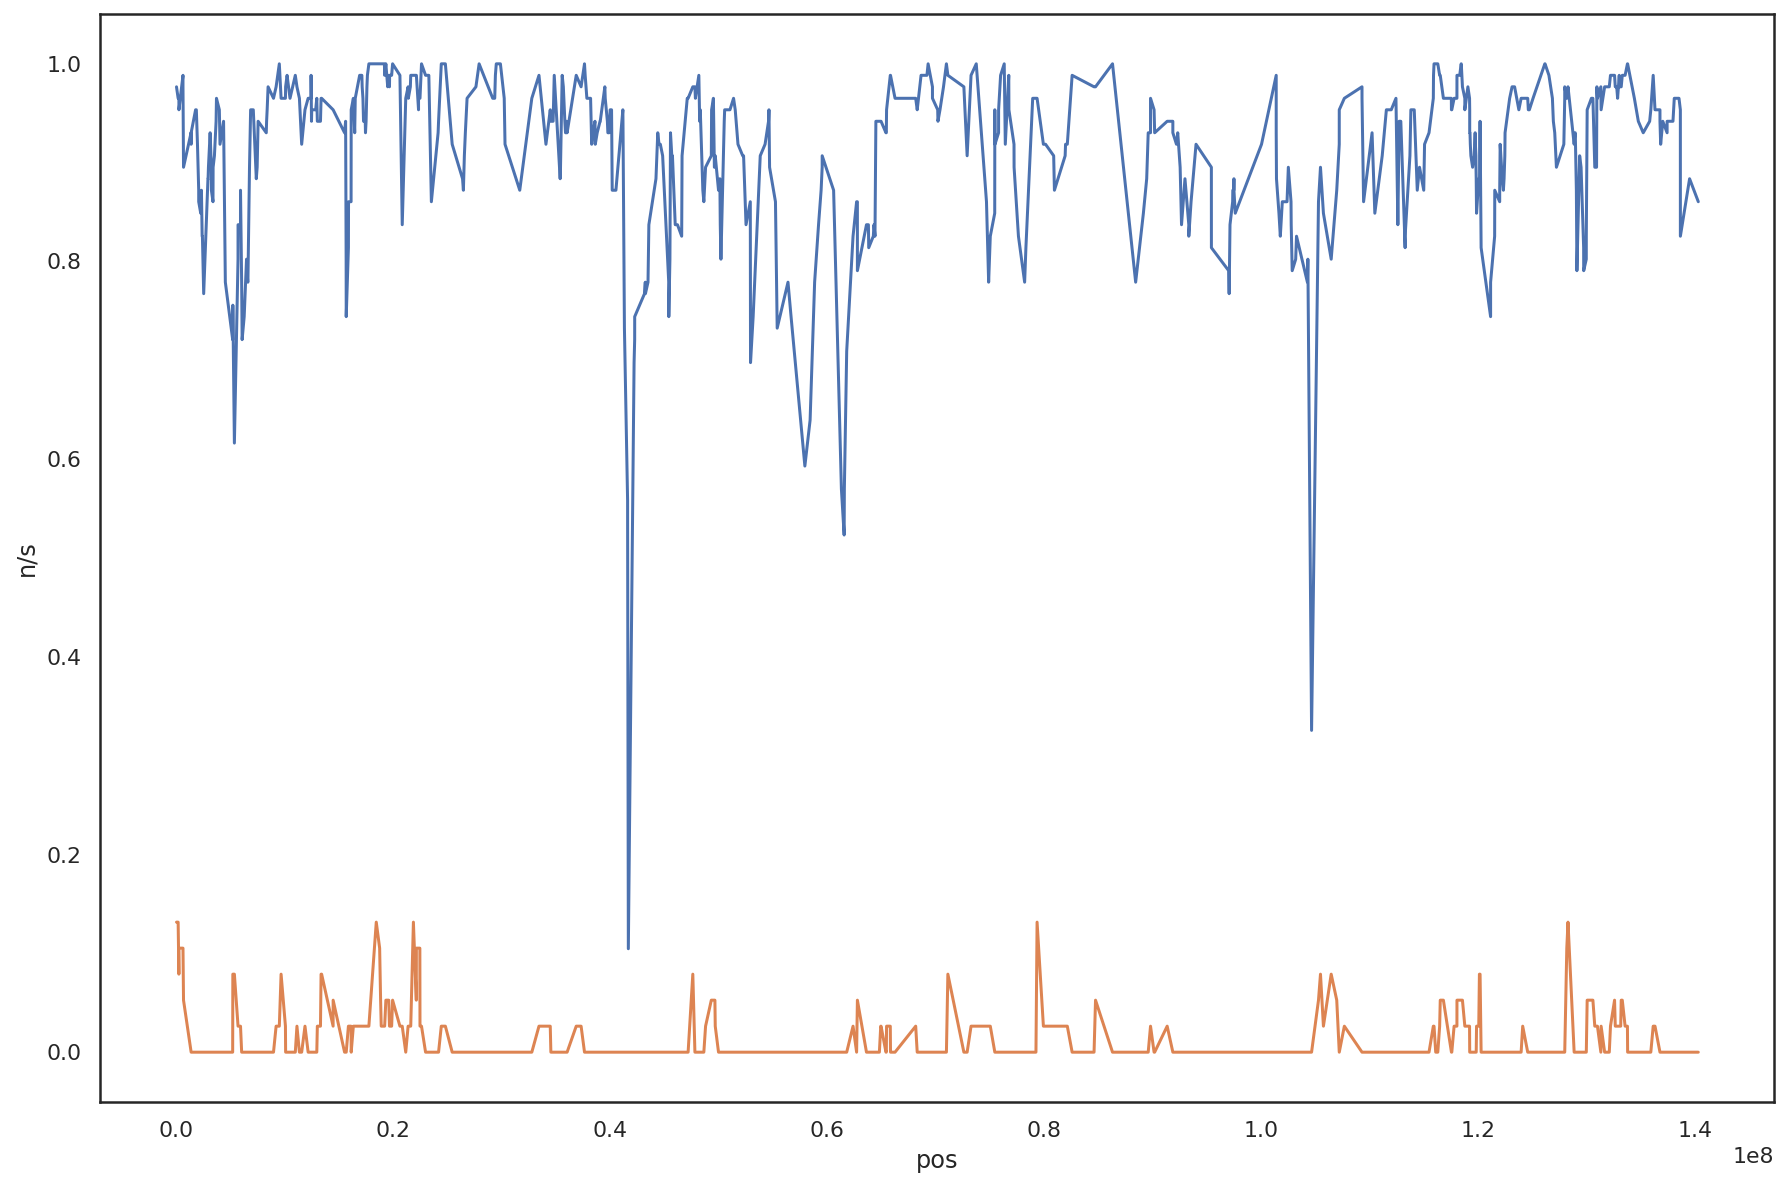

In [41]:
plt.figure(figsize=(15,10))
g = sns.lineplot(data=olive_tanzania, x="pos", y="n/s")
g = sns.lineplot(data=eastern_yellow, x="pos", y="n/s")
#g = sns.lineplot(data=issa, x="pos", y="n/s")


In [42]:
stats.spearmanr(olive_tanzania["n/s"], eastern_yellow["n/s"])

SpearmanrResult(correlation=0.35165167026744115, pvalue=3.525572696030657e-18)

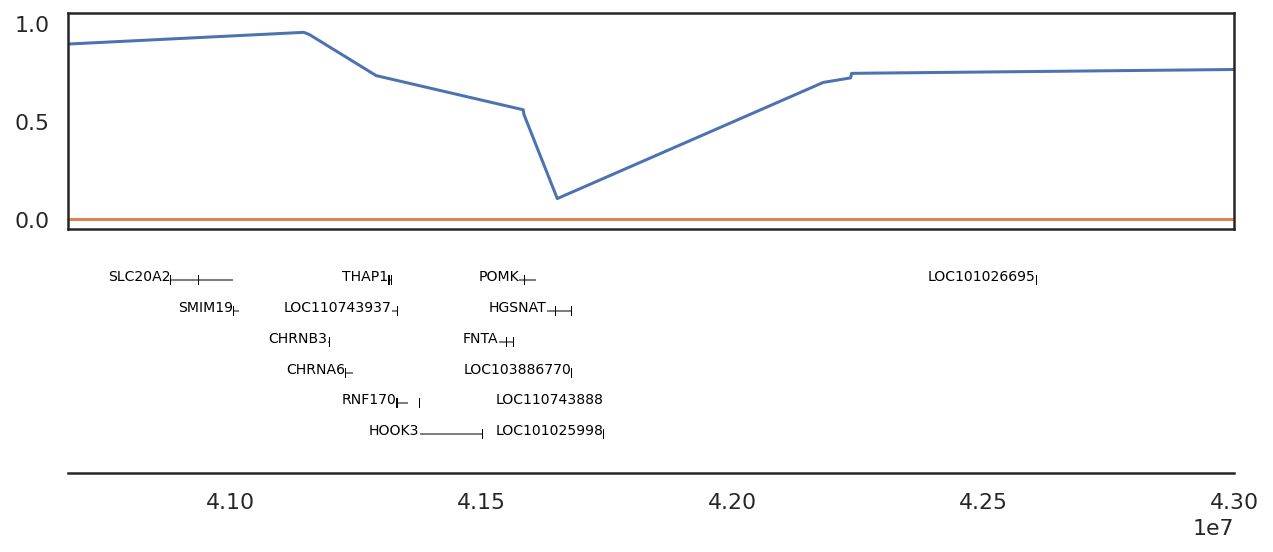

In [43]:
ax = gi.gene_plot('chr8', 41000000, 43000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

In [44]:
window_size = 100000

relate_sele = pd.read_csv("../results/all_individuals_relate/chrom8_selection.sele", sep=" ")
relate_sele["-log10 P-value"] = -relate_sele["when_mutation_has_freq2"]

In [49]:
relate_sele.loc[(relate_sele.pos > 135000000)
                & (relate_sele.pos < 139877354)].sort_values(by= "-log10 P-value")[-20:]

,pos,rs_id,3571428.500000,357142.937500,257030.656250,184981.281250,133128.375000,95810.585938,68953.507812,49624.847656,...,184.981262,133.128357,95.810577,68.953499,49.624844,35.714287,0.000000,when_DAF_is_half,when_mutation_has_freq2,-log10 P-value
3142137,137576566,8:137576566:G:C,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.00000,...,-1.830440,-1.373240,-0.913823,-0.588458,-0.737219,-0.433764,0,-2.358460,-6.49121,6.49121
3080201,135090332,8:135090332:T:C,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.00000,...,-0.229571,-0.155823,-0.101633,-0.023221,-0.019519,-0.033251,0,-0.719746,-6.55345,6.55345
3132403,137266109,8:137266109:G:A,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.00000,...,-1.143260,-0.527743,-0.843850,-0.469413,-0.370549,-0.023948,0,-2.397100,-6.59081,6.59081
3084571,135282236,8:135282236:C:T,1,1.0,1.0,1.0,1.0,1.0,-6.63176,-5.68143,...,-0.089052,-0.034045,-0.088102,-0.075951,-0.020085,-0.004442,0,-0.761454,-6.63176,6.63176
3097508,135805937,8:135805937:C:T,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.00000,...,-0.334366,-0.319101,-0.342998,-0.241052,-0.305000,-0.507952,0,-1.275760,-6.76001,6.76001
3106109,136164193,8:136164193:C:G,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.00000,...,-0.836153,-0.281522,-0.314853,-0.219273,-0.443565,-0.143431,0,-0.871546,-6.76760,6.76760
3093965,135659139,8:135659139:G:A,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.00000,...,-1.287400,-1.151390,-1.373000,-1.184440,-0.572945,-0.338924,0,-2.388680,-6.79531,6.79531
3116833,136717983,8:136717983:C:T,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.00000,...,-0.442444,-0.332712,-0.299434,-0.382243,-0.173702,-0.063964,0,-0.395119,-6.89712,6.89712
3121380,136895491,8:136895491:C:G,1,1.0,1.0,1.0,1.0,1.0,-6.94407,-5.64646,...,-1.062490,-0.689575,-0.835607,-0.492080,-0.259348,-0.116535,0,-2.367820,-6.94407,6.94407
3119017,136800825,8:136800825:G:T,1,1.0,1.0,1.0,1.0,1.0,1.00000,-6.58265,...,-0.570285,-0.374082,-0.405121,-0.182478,-0.190478,-0.090657,0,-1.030500,-7.11938,7.11938


In [50]:
relate_sele.loc[(relate_sele.pos > 65000000)
                & (relate_sele.pos < 69000000)].sort_values(by= "-log10 P-value")[-20:]

,pos,rs_id,3571428.500000,357142.937500,257030.656250,184981.281250,133128.375000,95810.585938,68953.507812,49624.847656,...,184.981262,133.128357,95.810577,68.953499,49.624844,35.714287,0.000000,when_DAF_is_half,when_mutation_has_freq2,-log10 P-value
1568474,66801632,8:66801632:A:T,1,1.0,1.0,1.0,1.0,-5.58677,-5.19016,-4.89057,...,-0.349631,-0.718187,-0.588089,-0.435779,-0.326728,-0.244344,0,-0.720705,-5.58677,5.58677
1567846,66764491,8:66764491:T:C,1,1.0,1.0,1.0,1.0,1.00000,1.00000,1.00000,...,-1.042200,-1.113860,-1.773720,-1.867920,-1.893630,-1.512050,0,-1.708920,-5.77903,5.77903
1541427,65378134,8:65378134:A:G,1,1.0,1.0,1.0,1.0,1.00000,-5.80067,-4.52545,...,-1.243370,-1.208700,-0.703856,-0.681226,-0.692330,-0.333438,0,-1.447950,-5.80067,5.80067
1609935,68847015,8:68847015:A:G,1,1.0,1.0,1.0,1.0,1.00000,1.00000,1.00000,...,-3.690150,-3.286270,-2.146790,-1.353000,-1.134880,-0.789654,0,-3.496960,-5.80711,5.80711
1609934,68847014,8:68847014:C:A,1,1.0,1.0,1.0,1.0,1.00000,1.00000,1.00000,...,-3.690150,-3.286270,-2.146790,-1.353000,-1.134880,-0.789654,0,-3.496960,-5.80711,5.80711
1596544,68243080,8:68243080:A:G,1,1.0,1.0,1.0,1.0,1.00000,1.00000,-5.82015,...,-0.507621,-1.218450,-1.039200,-1.345920,-0.604580,-0.405423,0,-0.810084,-5.82015,5.82015
1596539,68242889,8:68242889:T:C,1,1.0,1.0,1.0,1.0,1.00000,1.00000,-5.82015,...,-0.507621,-1.218450,-1.039200,-1.345920,-0.604580,-0.405423,0,-0.810084,-5.82015,5.82015
1608533,68781570,8:68781570:G:T,1,1.0,1.0,1.0,1.0,-5.88070,-5.88070,-6.16639,...,-2.016450,-1.965500,-1.914180,-1.513790,-1.492800,-1.066570,0,-1.611240,-5.88070,5.88070
1590646,67964753,8:67964753:G:C,1,1.0,1.0,1.0,1.0,1.00000,1.00000,1.00000,...,-0.836232,-0.559512,-0.804006,-0.746454,-0.512969,-0.488928,0,-0.614251,-6.01538,6.01538
1565482,66641005,8:66641005:C:T,1,1.0,1.0,1.0,1.0,-5.55464,-6.79357,-6.79357,...,-0.592613,-0.793710,-0.601701,-0.862439,-0.662310,-0.482060,0,-1.456960,-6.02636,6.02636


In [48]:
list(relate_sele.loc[(relate_sele.pos > 135000000)
                & (relate_sele.pos < 139877354)].sort_values(by= "-log10 P-value")[-20:].pos)

[137576566,
 135090332,
 137266109,
 135282236,
 135805937,
 136164193,
 135659139,
 136717983,
 136895491,
 136800825,
 136387268,
 136822194,
 136092096,
 136082477,
 136280537,
 138160118,
 136098298,
 135090234,
 137558239,
 136441507]

In [47]:
relate_sele.sort_values(by= "-log10 P-value")[-20:]

,pos,rs_id,3571428.500000,357142.937500,257030.656250,184981.281250,133128.375000,95810.585938,68953.507812,49624.847656,...,184.981262,133.128357,95.810577,68.953499,49.624844,35.714287,0.000000,when_DAF_is_half,when_mutation_has_freq2,-log10 P-value
925464,37193799,8:37193799:A:G,1,1.0,1.0,1.0,1.0,1.0,1.00000,-8.12616,...,-1.528730,-1.207930,-0.894195,-0.671481,-0.427138,-0.239943,0,-3.269310,-8.66771,8.66771
405789,15336351,8:15336351:T:C,1,1.0,1.0,1.0,1.0,1.0,-8.12616,-8.12616,...,-0.682922,-0.449304,-0.747451,-0.551775,-0.383666,-0.256484,0,-1.439150,-8.66771,8.66771
487983,18159521,8:18159521:C:T,1,1.0,1.0,1.0,1.0,1.0,1.00000,-8.66771,...,-1.469190,-1.132180,-0.805502,-0.579024,-0.332401,-0.158089,0,-3.269310,-8.66771,8.66771
1927626,83662357,8:83662357:T:C,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.00000,...,-0.119953,-0.052871,-0.006002,-0.006840,-0.012677,-0.055195,0,-0.462328,-8.67200,8.67200
1156749,48621100,8:48621100:T:C,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.00000,...,-0.346329,-0.534280,-0.456369,-0.375725,-0.674087,-0.272978,0,-0.481722,-8.69119,8.69119
550951,20609924,8:20609924:A:C,1,1.0,1.0,1.0,1.0,1.0,1.00000,-8.74810,...,-0.184310,-0.155577,-0.333567,-0.183234,-0.608815,-0.834395,0,-0.573655,-8.74810,8.74810
2544375,113318787,8:113318787:T:C,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.00000,...,-1.579640,-1.351240,-1.598940,-1.096100,-0.520184,-0.225815,0,-1.758500,-8.84810,8.84810
1327333,55526678,8:55526678:C:T,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.00000,...,-0.684122,-0.337056,-0.437174,-0.532701,-0.382326,-0.080719,0,-1.957590,-8.90166,8.90166
2362204,105677034,8:105677034:A:G,1,1.0,1.0,1.0,1.0,1.0,-8.99112,-10.08960,...,-0.661553,-0.428509,-0.242426,-0.115042,-0.190041,-0.079500,0,-1.905030,-8.99112,8.99112
2911844,128876165,8:128876165:C:A,1,1.0,1.0,1.0,1.0,1.0,1.00000,1.00000,...,-2.051700,-1.298060,-0.912984,-0.631978,-0.529680,-0.205473,0,-3.399240,-9.12440,9.12440
